In [169]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import datetime
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.preprocessing import MinMaxScaler

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')


In [372]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [385]:
df_test = pd.read_csv("data/sag_data_test.csv", index_col="Time", parse_dates=True)
df_train = pd.read_csv("data/sag_data_train.csv", index_col="Time", parse_dates=True)
df_train = df_train.interpolate()
features = df_test.columns[2:].values
targets = df_test.columns[:2].values
print('Features: {}'.format(features))
print('Targets: {}'.format(targets))

Features: ['Speed (RPM)' 'Dilution Flow Rate (m3/h)' 'Conveyor Belt Feed Rate (t/h)'
 'Conveyor Belt PSD Fines (%)']
Targets: ['Bearing Pressure (kPa)' 'Power Draw (MW)']


<AxesSubplot:xlabel='Time'>

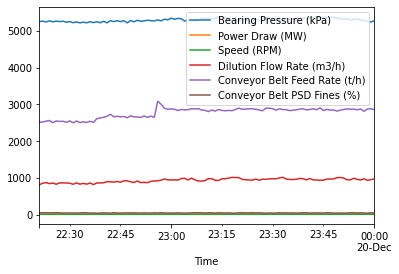

In [396]:
df_train = df_train[-100:]
df_train.plot()

### Preprocess the data

1-2 missing values in the train data set, which we can interpolate


In [387]:
# Using multiple features (predictors)
training_set = df_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (4000, 6).


array([[5232.25731978,   13.67831674,    8.59024115,  616.48337579,
        1691.94124363,   25.37833595],
       [5222.301615  ,   13.74716807,    8.6997077 ,  616.12770488,
        1865.21114143,   26.11239624],
       [5206.01658368,   13.75444205,    8.65412398,  611.84250763,
        1093.88728767,   33.11492157],
       ...,
       [5260.32185763,   13.39287912,    8.40582645,  932.98246706,
        2877.57330422,   40.47877502],
       [5244.05488852,   13.10375519,    8.23960745,  951.28257792,
        2882.38539053,   47.95565796],
       [5281.92105959,   13.02409458,    8.15488899,  971.2098861 ,
        2861.21127905,   47.9231987 ]])

In [388]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.34681462],
       [0.26724671],
       [0.1370936 ],
       ...,
       [0.57111182],
       [0.44110306],
       [0.7437368 ]])

In [389]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 5   # Number of days we want top predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3936, 60, 6).
y_train shape == (3936, 1).


In [390]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [393]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_train.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss=tf.keras.losses.MeanAbsoluteError())

NameError: name 'tf' is not defined

In [394]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [316]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

449/449 [==============================] - 1s 3ms/step


In [317]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

In [322]:
y_pred_future

array([[5359.411 ],
       [5365.2153],
       [5350.8096],
       [5328.3975],
       [5319.35  ]], dtype=float32)

<AxesSubplot:xlabel='Time'>

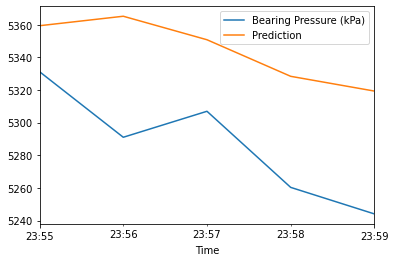

In [348]:
df_train.tail(5)

df_preds = pd.DataFrame(df_train[-6:-1]['Bearing Pressure (kPa)'].copy())
df_preds['Prediction'] = y_pred_future
df_preds.plot()

In [344]:

pd.concat([df_preds,  pd.DataFrame(y_pred_future, columns =['Bearing Pressure Pred'], index = df_preds.index)])

,Bearing Pressure (kPa),Bearing Pressure Pred
Time,,
2015-12-19 23:55:00,5331.208153,NaN
2015-12-19 23:56:00,5291.038653,NaN
2015-12-19 23:57:00,5306.966515,NaN
2015-12-19 23:58:00,5260.321858,NaN
2015-12-19 23:59:00,5244.054889,NaN
2015-12-19 23:55:00,NaN,5359.411133
2015-12-19 23:56:00,NaN,5365.215332
2015-12-19 23:57:00,NaN,5350.809570
2015-12-19 23:58:00,NaN,5328.397461


In [154]:
print('Train: ')
print(df_train.info())
print('\n\n')
print('Test: ')
print(df_test.info())

df_train = df_train.interpolate()

plot_df = df_train.copy()

scaler = MinMaxScaler()
scaler = scaler.fit(df_train)

#Let's save the scaler for inverse prediction of the target variable in the future
# scaler_prediction = MinMaxScaler()
# scaler_prediction.fit(df_train[:, 0:2])

df_train = pd.DataFrame(
    scaler.transform(df_train),
    index=df_train.index,
    columns=df_train.columns)

df_train.as_matrix()

Train: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138241 entries, 2015-09-15 00:00:00 to 2015-12-20 00:00:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Bearing Pressure (kPa)         138241 non-null  float64
 1   Power Draw (MW)                138241 non-null  float64
 2   Speed (RPM)                    138241 non-null  float64
 3   Dilution Flow Rate (m3/h)      138241 non-null  float64
 4   Conveyor Belt Feed Rate (t/h)  138241 non-null  float64
 5   Conveyor Belt PSD Fines (%)    138241 non-null  float64
dtypes: float64(6)
memory usage: 7.4 MB
None



Test: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28801 entries, 2015-12-21 00:00:00 to 2016-01-10 00:00:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Bearing Pressure (kPa)         28801 

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

## Explore the data

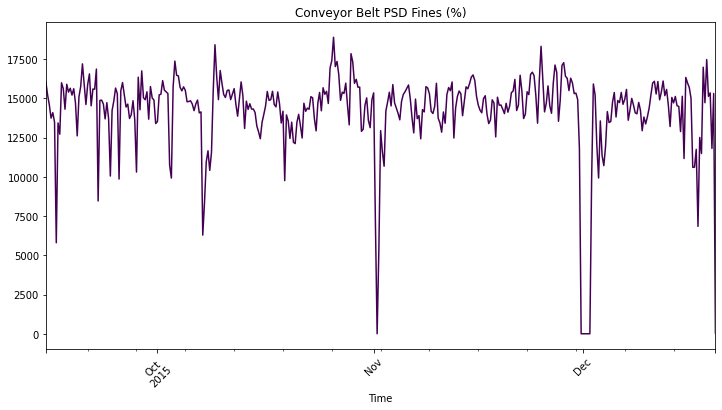

In [118]:
plot_df_hourly = plot_df.resample('6H').sum()
plot_col = features[3]
plot_df_hourly[plot_col].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title(plot_col)
plt.show()

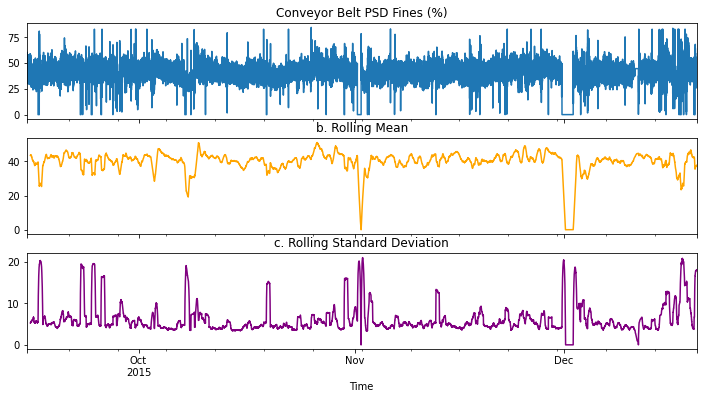

In [146]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df[plot_col].plot(ax=axes[0], figsize=(12,6), rot=90, title=plot_col, sharex=True)
plot_df[plot_col].rolling(720).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df[plot_col].rolling(720).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

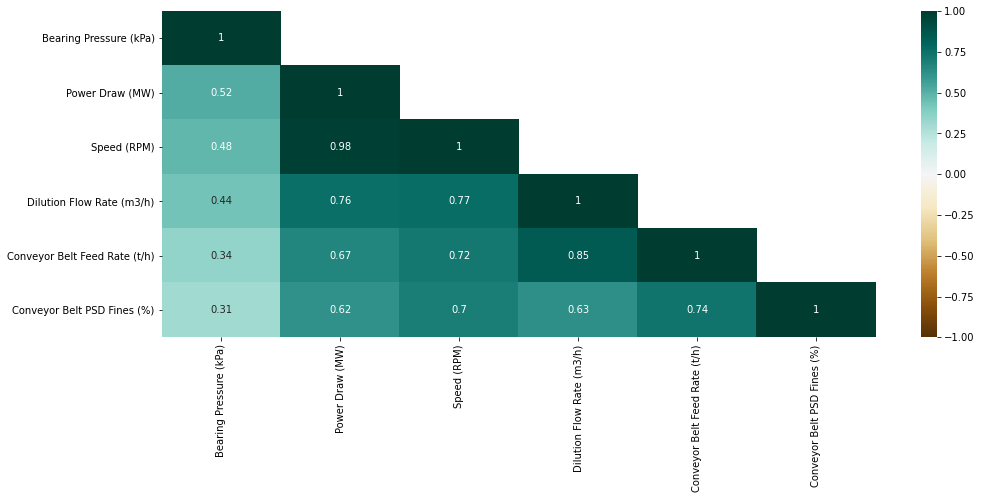

In [138]:
import seaborn as sns
plt.figure(figsize = (16,6))

mask = np.triu(np.ones_like(df_train.corr(), dtype=bool), +1)
heatmap = sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, mask = mask, annot = True, cmap = 'BrBG')


In [104]:
plot_df

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-09-15 00:00:00,5488.175540,11.737357,7.843532,1030.590108,2935.660276,38.641018
2015-09-15 00:01:00,5423.930126,11.543755,7.681607,1039.869847,2928.333772,45.243656
2015-09-15 00:02:00,5502.058523,11.169525,7.514173,1033.237205,2919.128115,38.716221
2015-09-15 00:03:00,5477.862749,11.035091,7.592248,1035.075573,2985.500811,42.860703
2015-09-15 00:04:00,5508.013201,11.418827,7.784895,1042.189406,2905.052105,50.524544
...,...,...,...,...,...,...
2015-12-19 23:56:00,5291.038653,13.661863,8.709156,943.244733,2876.678675,50.263821
2015-12-19 23:57:00,5306.966515,13.610935,8.603212,976.361162,2813.859524,44.921227
2015-12-19 23:58:00,5260.321858,13.392879,8.405826,932.982467,2877.573304,40.478775


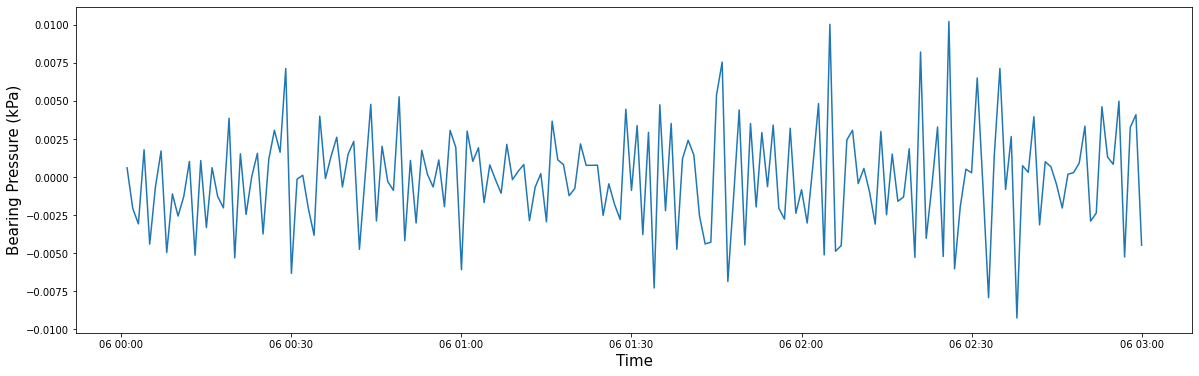

In [62]:
plot_day = '2015-10-06 00:00:00'
plot_endday = '2015-10-06 03:00:00'
df_plot = df_train.loc[plot_day:plot_endday]
plt.figure(figsize = (20,6))
plt.plot(df_plot[targets[0]].pct_change(1))
plt.xlabel('Time',fontsize=15)
plt.ylabel(targets[0],fontsize=15)
plt.show()



In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

In [8]:
df_train

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-09-15 00:00:00,5488.175540,11.737357,7.843532,1030.590108,2935.660276,38.641018
2015-09-15 00:01:00,5423.930126,11.543755,7.681607,1039.869847,2928.333772,45.243656
2015-09-15 00:02:00,5502.058523,11.169525,7.514173,1033.237205,2919.128115,38.716221
2015-09-15 00:03:00,5477.862749,11.035091,7.592248,1035.075573,2985.500811,42.860703
2015-09-15 00:04:00,5508.013201,11.418827,7.784895,1042.189406,2905.052105,50.524544
...,...,...,...,...,...,...
2015-12-19 23:56:00,5291.038653,13.661863,8.709156,943.244733,2876.678675,50.263821
2015-12-19 23:57:00,5306.966515,13.610935,8.603212,976.361162,2813.859524,44.921227
2015-12-19 23:58:00,5260.321858,13.392879,8.405826,932.982467,2877.573304,40.478775


##  Modeling 
- Long Short-Term Memory (LSTM): Originally developed for Natural Language Processing (NLP) tasks, LSTM models have made their way into the time series forecasting domain because, as with text, time series data occurs in sequence and temporal relationships between different parts of the sequence matter for determining a prediction outcome.

- Our specific forecasting model consists of two LSTM layers followed by one fully connected layer to predict the following day’s price. We employ a dataset class to generate time series of our feature set with a sequence length of 30 days and a dataloader class to load them in batches. We train the model using the Adam optimizer and RMSE as well as MSE as loss functions (during separate runs). Furthermore, we implement early-stopping to allow the training job to finish early if there are no significant performance improvements.

In [140]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Power Draw (MW)'

In [141]:
hist = train.train_model(df_train, df_test, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

NameError: name 'train' is not defined